# Task 2- CREDIT CARD FRAUD DETECTION



In [32]:
pip install category_encoders

In [54]:
pip install StandardScaler

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split


In [34]:
train_df = pd.read_csv("/content/drive/MyDrive/Codsoft/fraudTrain.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Codsoft/fraudTest.csv")

In [35]:
train_df.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [37]:
train_df.shape

(1296675, 23)

In [38]:
is_fraud = train_df["is_fraud"].value_counts()
print("Yes: ",is_fraud[1])
print("No: ",is_fraud[0])

Yes:  7506
No:  1289169


In [39]:
print(train_df.isna().sum().sum())
print(train_df.duplicated().sum())

0
0


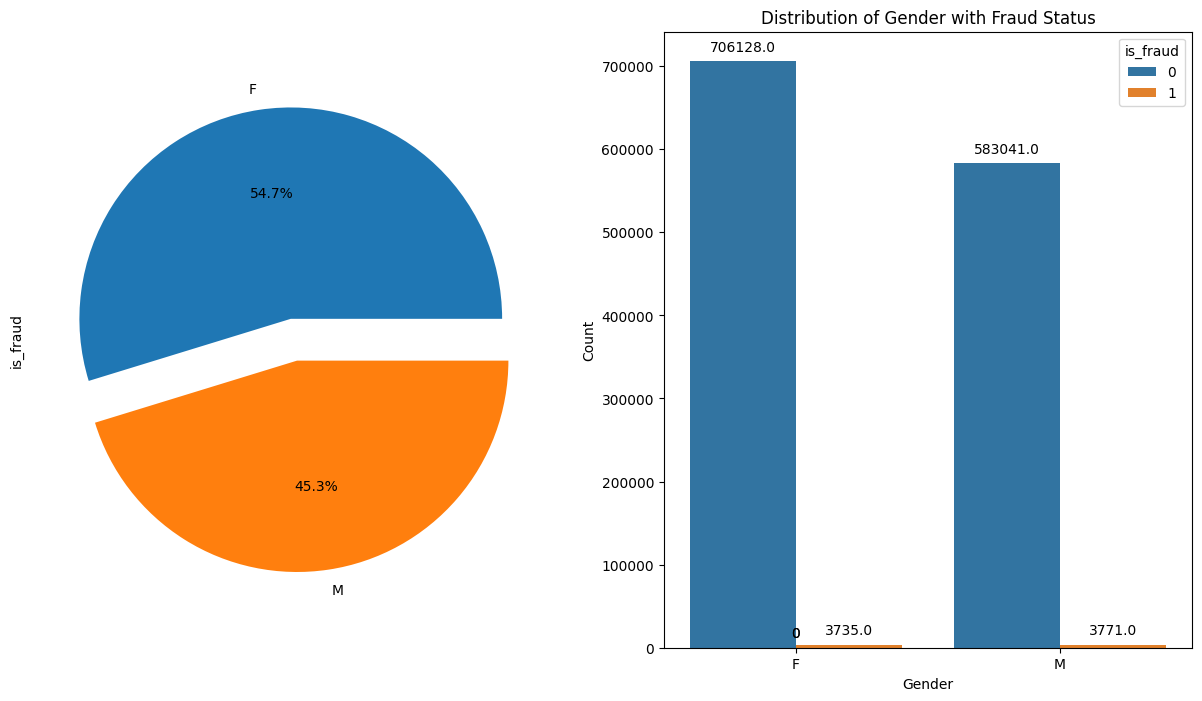

In [40]:
fig,axb = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))

explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%",ax=axb[0]);

ax = sns.countplot(x="gender", hue="is_fraud", data=train_df,ax=axb[1])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title("Distribution of Gender with Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Count")

plt.show()

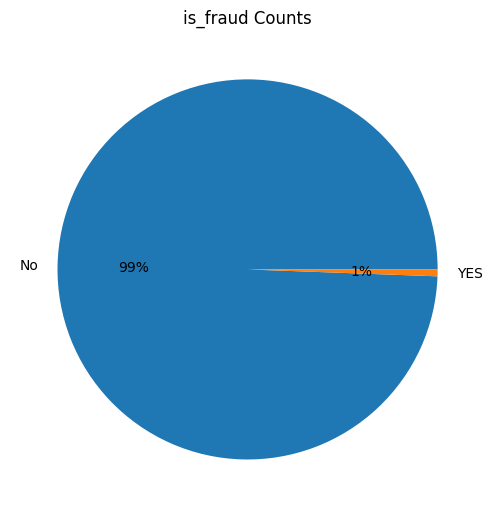

In [55]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()
plt.show()

99% is not fraud and only 1% is fraud leads to imbalanced data

In [42]:
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'])
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'])

In [43]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1


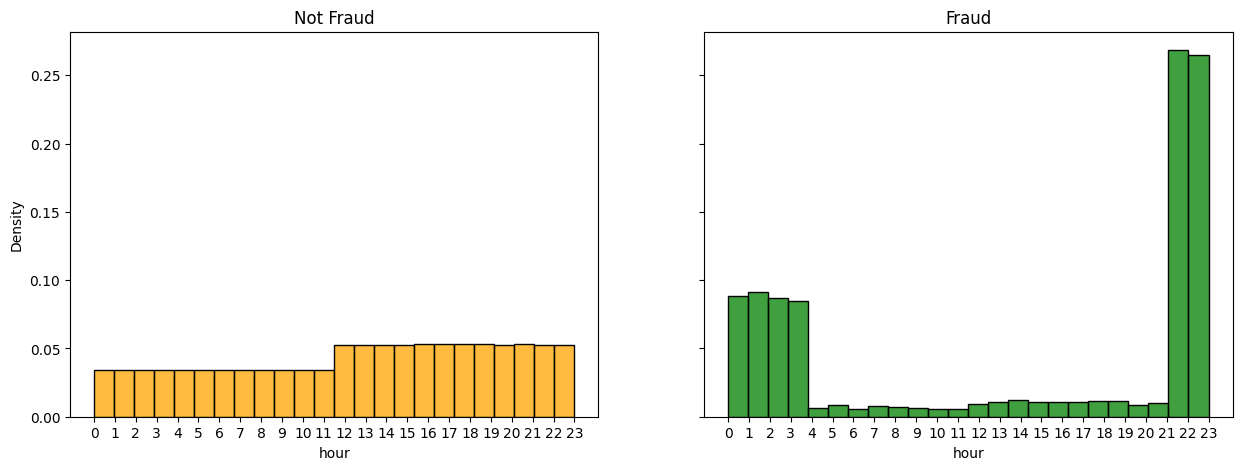

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax1 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="orange")

ax2 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="green")

ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

ax1.set_xticks(np.arange(24)) # ticks of the day 0 -> 23
ax2.set_xticks(np.arange(24));

# Data Pre-processing

In [45]:
unique_transaction_count = len(train_df['trans_num'].unique())
print("Total count of unique transaction numbers:", unique_transaction_count)

Total count of unique transaction numbers: 1296675


In [46]:
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

,Unnamed: 0,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


In [47]:
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 15 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1296675 non-null  int64  
 1   merchant    1296675 non-null  object 
 2   category    1296675 non-null  object 
 3   amt         1296675 non-null  float64
 4   last        1296675 non-null  object 
 5   gender      1296675 non-null  object 
 6   lat         1296675 non-null  float64
 7   long        1296675 non-null  float64
 8   city_pop    1296675 non-null  int64  
 9   job         1296675 non-null  object 
 10  merch_lat   1296675 non-null  float64
 11  merch_long  1296675 non-null  float64
 12  is_fraud    1296675 non-null  int64  
 13  hour        1296675 non-null  int64  
 14  month       1296675 non-null  int64  
dtypes: float64(5), int64(5), object(5)
memory usage: 148.4+ MB


In [49]:
train_df.head(2)

,Unnamed: 0,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,0,"Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,1,"Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


In [50]:
train_df.describe(include='object')

,merchant,category,last,gender,job
count,1296675,1296675,1296675,1296675,1296675
unique,693,14,481,2,494
top,Kilback LLC,gas_transport,Smith,F,Film/video editor
freq,4403,131659,28794,709863,9779


# Data Encoding

In [51]:
train_df['gender'] = train_df['gender'].map({'F': 0, 'M': 1})

for col in ['job','merchant', 'category', 'lat', 'last']:
    train_df[col] = WOEEncoder().fit_transform(train_df[col],train_df['is_fraud'])

In [52]:
train_df.head(5)

,Unnamed: 0,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,0,0.959326,0.924914,4.97,-2.469513,0,36.0788,-81.1781,3495,-1.080186,36.011293,-82.048315,0,0,1
1,1,0.663187,0.898799,107.23,-0.673638,0,48.8878,-118.2105,149,-0.904144,49.159047,-118.186462,0,0,1
2,2,-0.790166,-0.847622,220.11,0.433257,1,42.1808,-112.2620,4154,1.120434,43.150704,-112.154481,0,0,1
3,3,-0.416817,-0.209382,45.00,0.148996,1,46.2306,-112.1138,1939,0.361872,47.034331,-112.561071,0,0,1
4,4,-0.277905,-0.611091,41.96,0.423436,1,38.4207,-79.4629,99,-2.464077,38.674999,-78.632459,0,0,1


# Down-Sampling and Scaling

In [53]:
No_class = train_df[train_df["is_fraud"]==0]
yes_class = train_df[train_df["is_fraud"]==1]

No_class = resample(No_class, replace=False, n_samples=len(yes_class))
down_samples = pd.concat([yes_class, No_class], axis=0)


X = down_samples.drop("is_fraud", axis=1)
y = down_samples["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

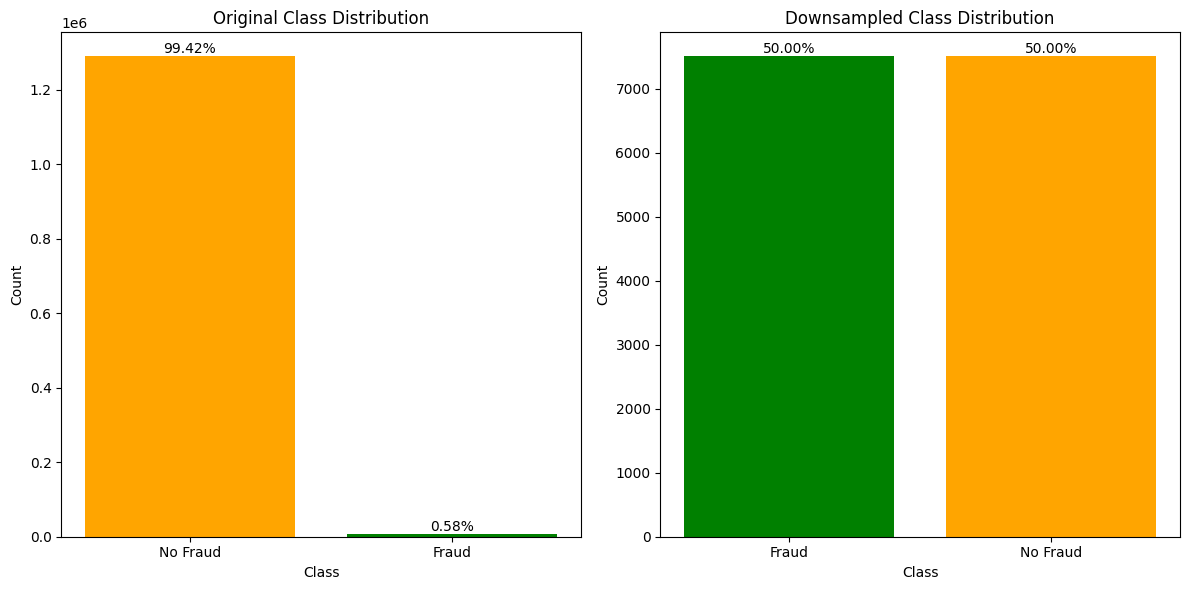

In [56]:
original_class_counts = train_df["is_fraud"].value_counts()

downsampled_class_counts = down_samples["is_fraud"].value_counts()

original_percentages = original_class_counts / len(train_df) * 100
downsampled_percentages = downsampled_class_counts / len(down_samples) * 100

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bars_1 = plt.bar(original_class_counts.index, original_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_1, original_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(original_class_counts.index, ['No Fraud', 'Fraud'])

plt.subplot(1, 2, 2)
bars_2 = plt.bar(downsampled_class_counts.index, downsampled_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_2, downsampled_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Downsampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(downsampled_class_counts.index, ['No Fraud', 'Fraud'])

plt.tight_layout()
plt.show()

# Logistic regression

In [57]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
predict_LR = LR_model.predict(X_test)
print(classification_report(y_test, predict_LR))
LR_accuracy = accuracy_score(predict_LR,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1486
           1       0.91      0.77      0.83      1517

    accuracy                           0.84      3003
   macro avg       0.85      0.84      0.84      3003
weighted avg       0.85      0.84      0.84      3003

Logistic Regression accuracy is: 84.35%


# Support vector machine

In [58]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
predict = svm_model.predict(X_test)

print(classification_report(y_test, predict))
svm_accuracy = accuracy_score(predict,y_test)
print('SVC model accuracy is: {:.2f}%'.format(svm_accuracy*100))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1486
           1       0.92      0.75      0.83      1517

    accuracy                           0.84      3003
   macro avg       0.86      0.84      0.84      3003
weighted avg       0.86      0.84      0.84      3003

SVC model accuracy is: 84.32%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Decision Tree

In [59]:
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(X_train, y_train)
predict_ID3 = DT.predict(X_test)
print(classification_report(y_test, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3,y_test)
print('ID3 model accuracy is: {:.2f}%'.format(ID3_accuracy*100))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1486
           1       0.97      0.74      0.84      1517

    accuracy                           0.86      3003
   macro avg       0.88      0.86      0.85      3003
weighted avg       0.88      0.86      0.85      3003

ID3 model accuracy is: 85.51%


# Random Forest

In [60]:
RF = RandomForestClassifier(n_estimators=100, random_state=0)
RF.fit(X_train, y_train)

predict_RF = RF.predict(X_test)

print(classification_report(y_test, predict_RF))
RF_accuracy = accuracy_score(predict_RF, y_test)
print('Random Forest model accuracy is: {:.2f}%'.format(RF_accuracy * 100))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1486
           1       0.98      0.97      0.97      1517

    accuracy                           0.97      3003
   macro avg       0.97      0.97      0.97      3003
weighted avg       0.97      0.97      0.97      3003

Random Forest model accuracy is: 97.07%


In [62]:
Algorithms = ['RandomForest','Logistic Regression', 'SVC']
accuracy = [RF_accuracy, LR_accuracy, svm_accuracy]

FinalResult=pd.DataFrame({'Algorithm':Algorithms, 'Accuracy':accuracy})

FinalResult

,Algorithm,Accuracy
0,RandomForest,0.970696
1,Logistic Regression,0.843490
2,SVC,0.843157


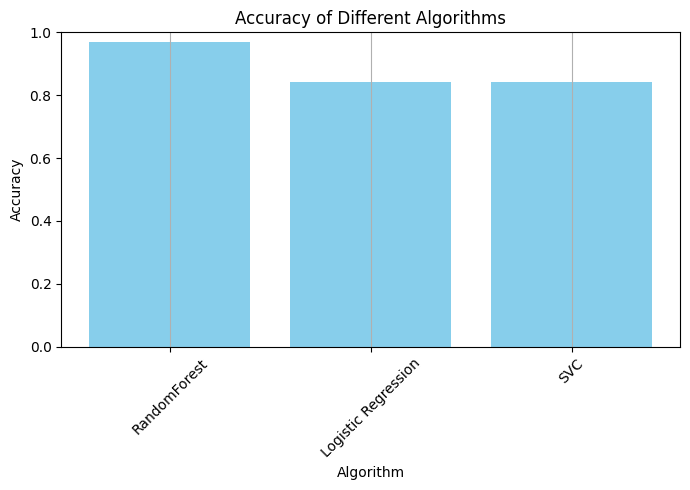

In [64]:
plt.figure(figsize=(7, 5))
plt.bar(FinalResult['Algorithm'], FinalResult['Accuracy'], color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='x')
plt.tight_layout()
plt.show()